# Figures and analysis for LEAFs paper

In [44]:
import sbtn_leaf.map_plotting as mp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import polars as pl
import rioxarray as rxr
import matplotlib as mpl
import importlib

## Results

### Terrestrial Acidification
Importing the needed data

In [2]:
# raster
nh3_raster_fp = "../LEAFs/acidification/rasters/acid_nh3.tif"
nox_raster_fp = "../LEAFs/acidification/rasters/acid_nox.tif"
so2_raster_fp = "../LEAFs/acidification/rasters/acid_so2.tif"

#geopackage
acid_er_geom = gpd.read_file("../LEAFs/acidification/soil_erosion_ecoregion.gpkg", layer="geometry_layer")
acid_er_vals = gpd.read_file("../LEAFs/acidification/soil_erosion_ecoregion.gpkg", layer="acid_leaf_ecoregions")

Preparing geopackage

In [3]:
acid_er = acid_er_geom.merge(acid_er_vals.drop(columns="_source_file"), how="left", on="ECO_ID")

In [4]:
acid_er.head()

,OBJECTID,ECO_NAME,BIOME_NUM,BIOME_NAME,REALM,ECO_BIOME_,ECO_ID,geometry,flow_name,cf,cf_median,cf_std
0,1.0,Adelie Land tundra,11.0,Tundra,Antarctica,AN11,117,"MULTIPOLYGON (((15313733.007 -6878278.25, 1531...",nh3,0.000000,0.000000,0.000000
1,1.0,Adelie Land tundra,11.0,Tundra,Antarctica,AN11,117,"MULTIPOLYGON (((15313733.007 -6878278.25, 1531...",nox,0.000000,0.000000,0.000000
2,1.0,Adelie Land tundra,11.0,Tundra,Antarctica,AN11,117,"MULTIPOLYGON (((15313733.007 -6878278.25, 1531...",so2,0.032829,0.045010,0.019801
3,2.0,Admiralty Islands lowland rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,135,"MULTIPOLYGON (((14211289.839 -328506.485, 1420...",nh3,0.083384,0.083798,0.002258
4,2.0,Admiralty Islands lowland rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,135,"MULTIPOLYGON (((14211289.839 -328506.485, 1420...",nox,0.017149,0.017326,0.000966


Reprojecting to Natural Earth

In [5]:
# geopackage
acid_er_ne = acid_er.to_crs("+proj=natearth")

In [6]:
# nh3
da = rxr.open_rasterio(nh3_raster_fp, masked=True)          # keeps nodata masked
da_ne = da.rio.reproject("+proj=natearth", resampling=1)  # 1 = bilinear
da_ne.rio.to_raster("../paper/acid_nh3_natear.tif")

# nox
da = rxr.open_rasterio(nox_raster_fp, masked=True)          # keeps nodata masked
da_ne = da.rio.reproject("+proj=natearth", resampling=1)  # 1 = bilinear
da_ne.rio.to_raster("../paper/acid_nox_natear.tif")

# so2
da = rxr.open_rasterio(so2_raster_fp, masked=True)          # keeps nodata masked
da_ne = da.rio.reproject("+proj=natearth", resampling=1)  # 1 = bilinear
da_ne.rio.to_raster("../paper/acid_so2_natear.tif")

In [7]:
mp.inspect_raster(so2_raster_fp)

File: ../LEAFs/acidification/rasters/acid_so2.tif
Driver: GTiff
Width, Height: 4320, 2083
Number of Bands: 1
CRS: EPSG:4326
Bounds: BoundingBox(left=-179.99999999999997, bottom=-89.99999999999994, right=179.99999999999991, top=83.58333333333331)
Pixel Size: (0.0833333333333333, 0.0833333333333333)
No-data Value: nan

--- Raster Metadata ---
AREA_OR_POINT: Area

--- Band Information ---

Band 1:
  Data Type: float64
  Min Value: 0.0
  Max Value: 10.813172542646374
  Mean Value: 0.6030503978571433
  Standard Deviation: 1.0425912985590675


Raster has 10,871 unique values. Min: 0.00. Max: 10.81
Using quantiles
All positives route (quantiles)


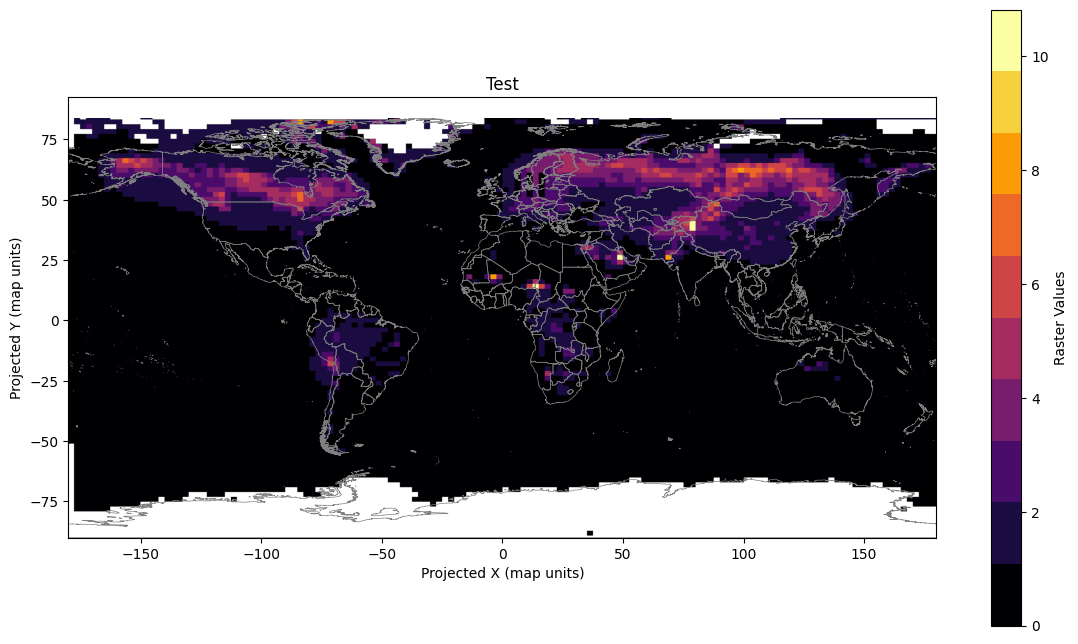

In [12]:
mp.plot_raster_on_world_extremes_cutoff(so2_raster_fp, title="Test", perc_cutoff=0, quantiles=10, cmap="inferno", eliminate_zeros=True)

Now plotting

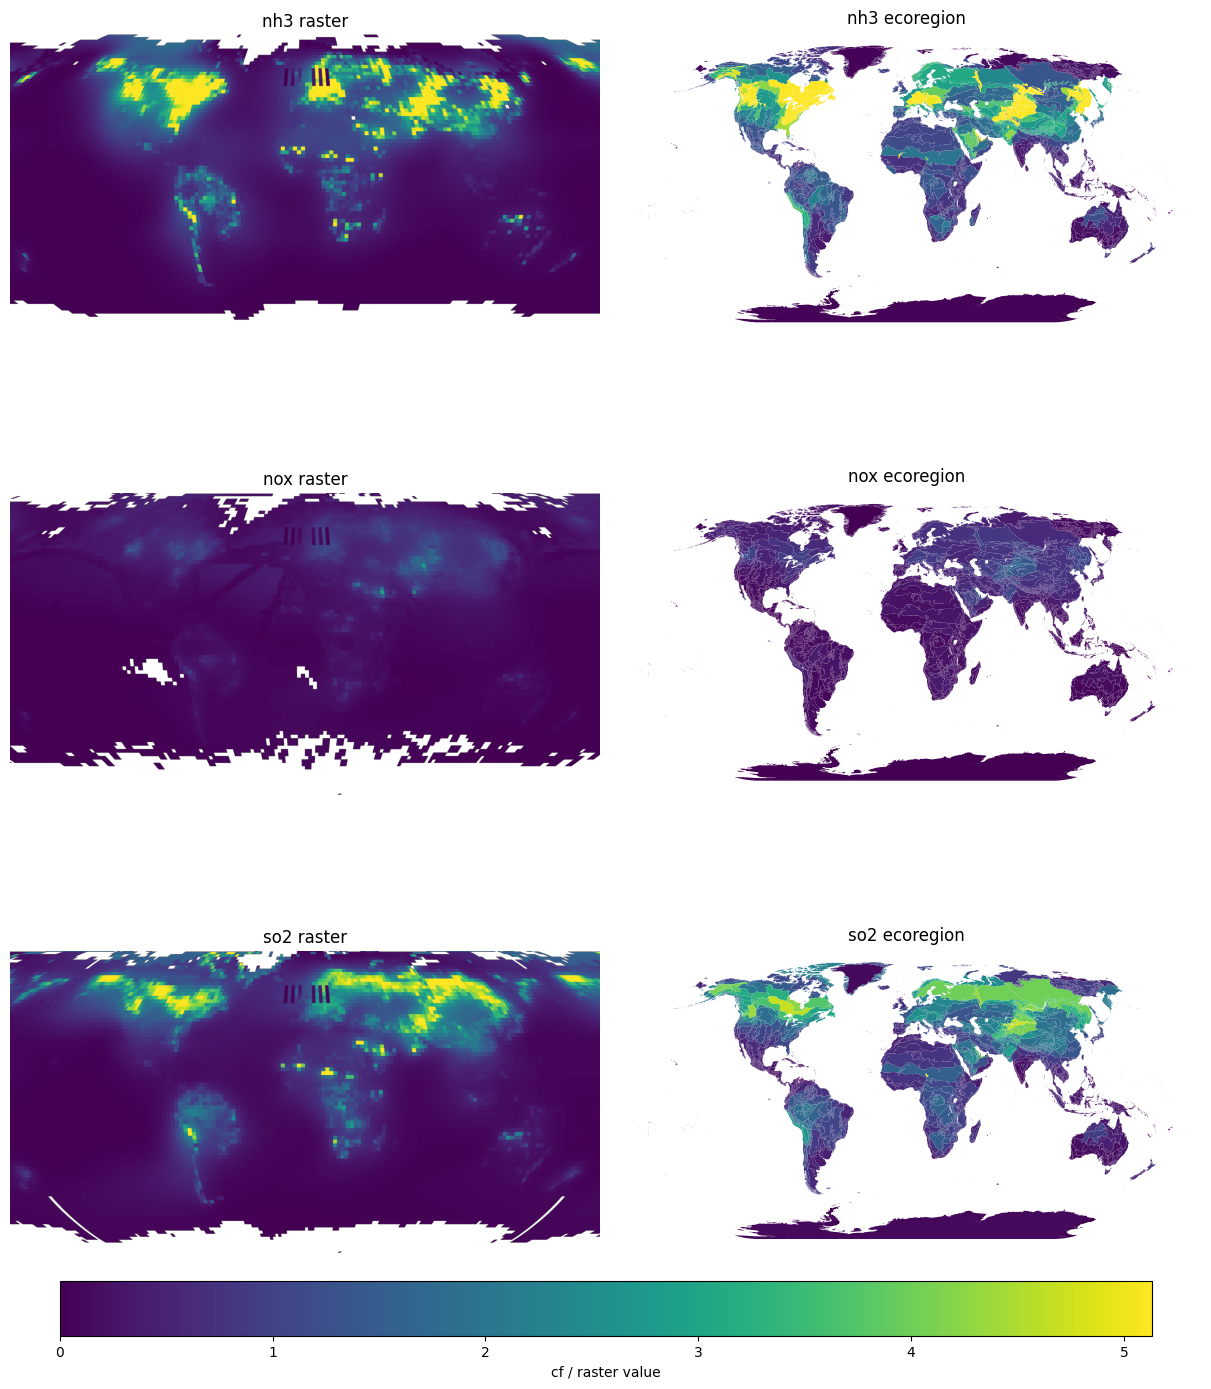

In [15]:
# paths for reprojected natearth rasters (written in an earlier cell)
nh3_ne_fp = "../paper/acid_nh3_natear.tif"
nox_ne_fp = "../paper/acid_nox_natear.tif"
so2_ne_fp = "../paper/acid_so2_natear.tif"

# open rasters (rioxarray already imported as rxr)
da_nh3 = rxr.open_rasterio(nh3_ne_fp, masked=True)
da_nox = rxr.open_rasterio(nox_ne_fp, masked=True)
da_so2 = rxr.open_rasterio(so2_ne_fp, masked=True)

# helper: always return a 2D float array with NaNs
def _arr2d(da):
    arr = da.squeeze().values  # (y,x) or (band,y,x) depending on file
    if arr.ndim == 3:
        arr = arr[0]
    if np.ma.isMaskedArray(arr):
        arr = arr.filled(np.nan)
    return arr.astype("float64", copy=False)

arrs = [_arr2d(da_nh3), _arr2d(da_nox), _arr2d(da_so2)]

# get cf values for each flow
flows = ["nh3", "nox", "so2"]
cf_vals = [
    acid_er_ne.loc[acid_er_ne["flow_name"] == f, "cf"].to_numpy(dtype="float64")
    for f in flows
]

# shared vmin/vmax across rasters and cf values
all_vals = np.concatenate([a.ravel() for a in arrs] + [v.ravel() for v in cf_vals])
all_vals = all_vals[np.isfinite(all_vals)]
# vmin, vmax = all_vals.min(), all_vals.max()
vmin, vmax = np.nanpercentile(all_vals, [1, 99])  # robust global scale

# plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15), constrained_layout=True)

cmap = "viridis"
das = [da_nh3, da_nox, da_so2]

for i, flow in enumerate(flows):
    ax_r = axes[i, 0]
    ax_m = axes[i, 1]

    da = das[i]
    arr = arrs[i]

    # mask zeros (do not plot them)
    arr = np.where(arr == 0, np.nan, arr)

    # extent from coordinates (convert to plain numpy floats)
    x0 = float(da["x"].values.min())
    x1 = float(da["x"].values.max())
    y0 = float(da["y"].values.min())
    y1 = float(da["y"].values.max())
    extent = (x0, x1, y0, y1)

    ax_r.imshow(arr, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent, origin="upper")
    ax_r.set_title(f"{flow} raster")
    ax_r.set_axis_off()

    subset = acid_er_ne[acid_er_ne["flow_name"] == flow]
    subset.plot(column="cf", ax=ax_m, cmap=cmap, vmin=vmin, vmax=vmax, edgecolor="none")
    ax_m.set_title(f"{flow} ecoregion")
    ax_m.set_axis_off()

# shared colorbar (don’t rely on a particular imshow handle)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation="horizontal", fraction=0.04, pad=0.02)
cbar.set_label("cf / raster value")

plt.show()

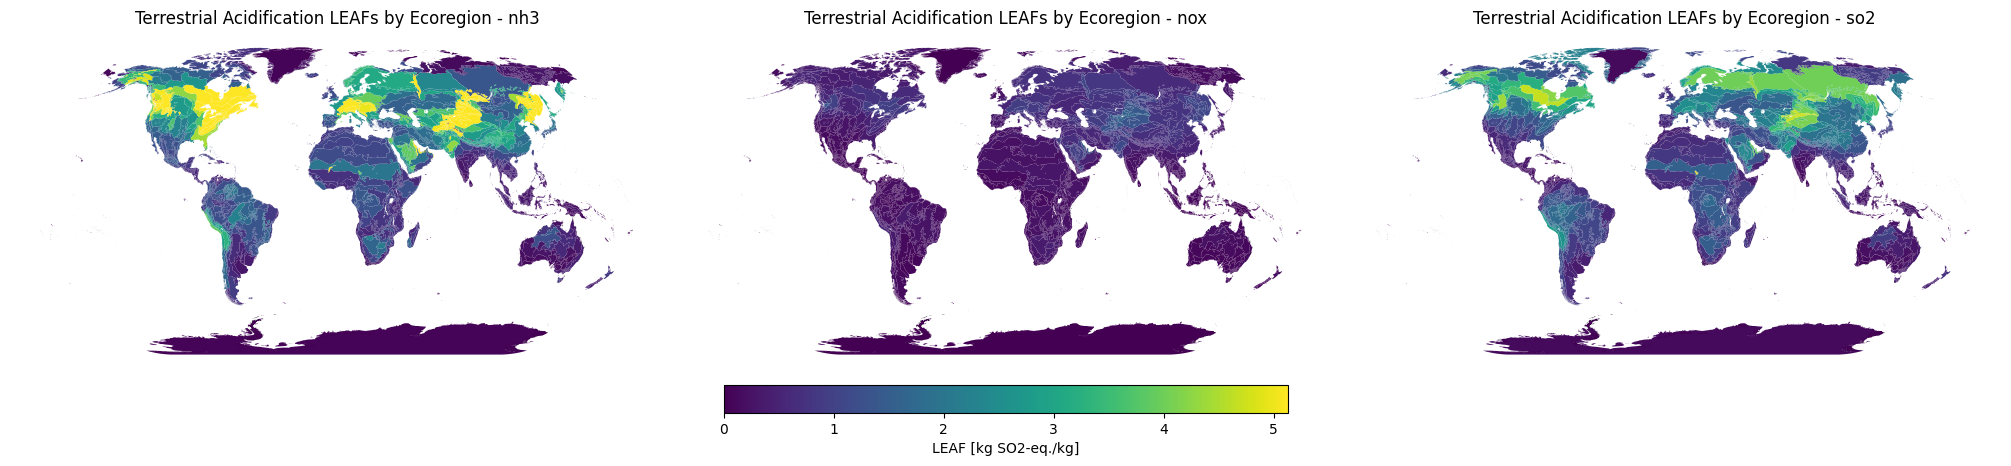

In [16]:
# plot cf for each flow_name (shared vmin/vmax and cmap from previous cells)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8), constrained_layout=True)

for ax, flow in zip(axes.ravel(), flows):
    subset = acid_er_ne[acid_er_ne["flow_name"] == flow]
    subset.plot(column="cf", ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, edgecolor="none")
    ax.set_title(f"Terrestrial Acidification LEAFs by Ecoregion - {flow}")
    ax.set_axis_off()

# shared colorbar
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=axes.ravel().tolist(), orientation="horizontal", fraction=0.04, pad=0.02).set_label("LEAF [kg SO2-eq./kg]")

plt.show()

Boxplot showing differences per realm

In [17]:
acid_er["flow_name"].unique()

array(['nh3', 'nox', 'so2'], dtype=object)

C:\Users\loyola\AppData\Local\Temp\ipykernel_10860\1796982283.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


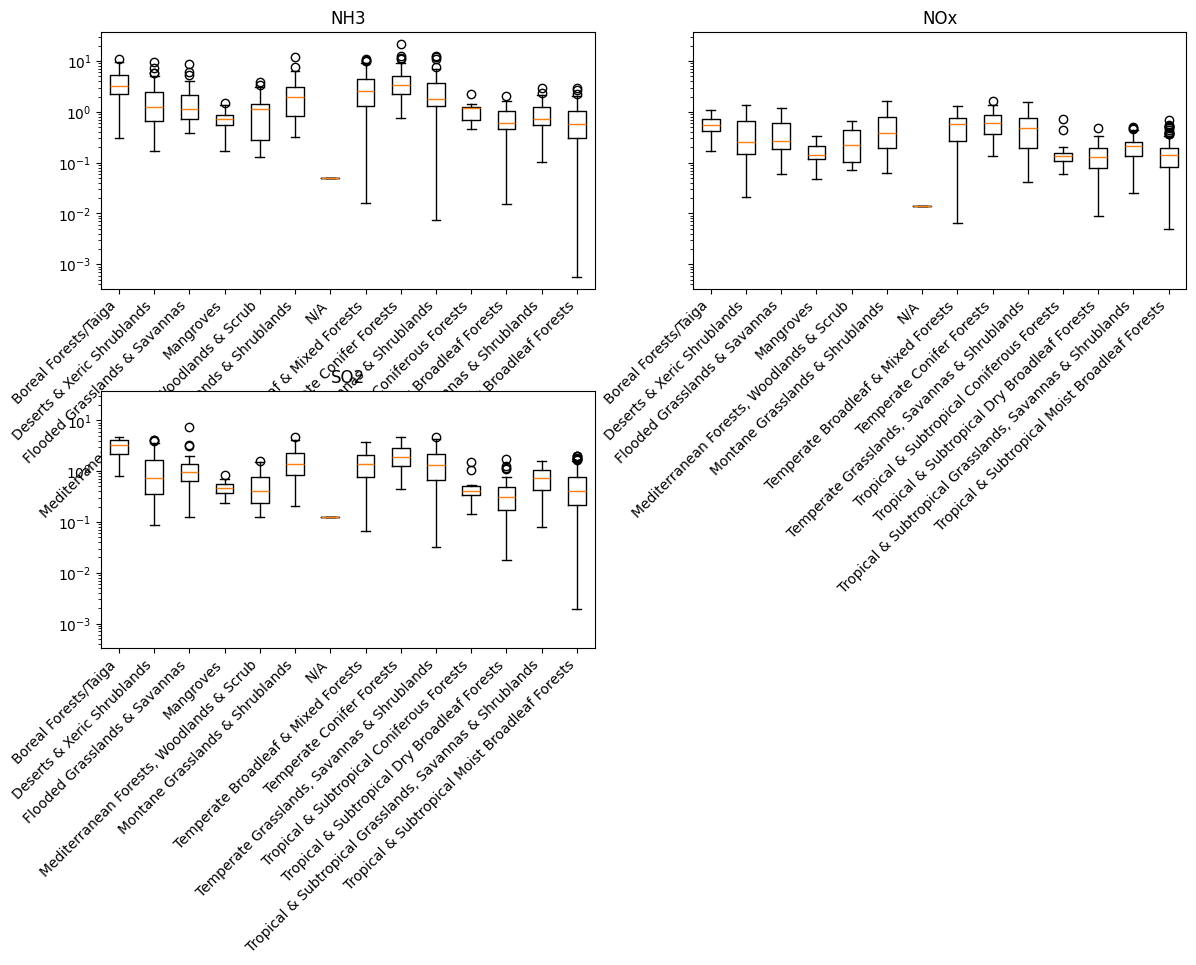

In [18]:
acid_er_noNA = acid_er[acid_er["BIOME_NAME"].notna() & acid_er["cf"].notna() & (acid_er["BIOME_NAME"] != "Tundra")]

def boxdata(df):
    labels = sorted(df["BIOME_NAME"].unique())
    data = [df.loc[df["BIOME_NAME"] == b, "cf"].values for b in labels]
    return data, labels

nh3_lfs = acid_er_noNA[acid_er_noNA["flow_name"] == "nh3"]
nox_lfs = acid_er_noNA[acid_er_noNA["flow_name"] == "nox"]
so2_lfs = acid_er_noNA[acid_er_noNA["flow_name"] == "so2"]

fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharey=True)

data, labels = boxdata(nh3_lfs)
axs[0, 0].boxplot(data, tick_labels=labels)
axs[0, 0].set_title("NH3")

data, labels = boxdata(nox_lfs)
axs[0, 1].boxplot(data, tick_labels=labels)
axs[0, 1].set_title("NOx")

data, labels = boxdata(so2_lfs)
axs[1, 0].boxplot(data, tick_labels=labels)
axs[1, 0].set_title("SO2")

for ax in axs.flat:
    ax.set_yscale("log")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Hide the unused 4th subplot
axs[1, 1].axis("off")

fig.subplots_adjust(hspace=0.4)
plt.show()


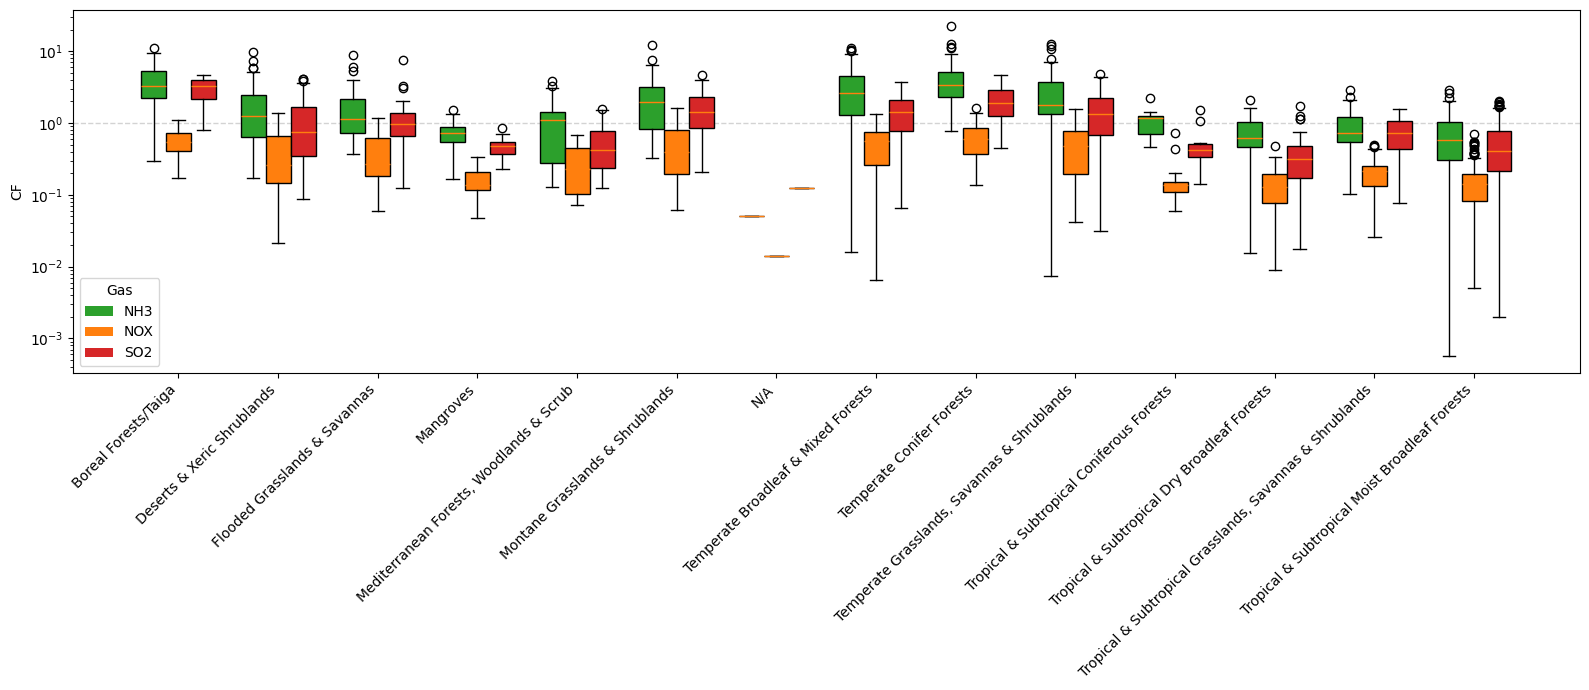

In [19]:
biomes = sorted(acid_er_noNA["BIOME_NAME"].unique())
flows = ["nh3", "nox", "so2"]
colors = {"nh3": "tab:green", "nox": "tab:orange", "so2": "tab:red"}

def collect_data(flow):
    df = acid_er_noNA[acid_er_noNA["flow_name"] == flow]
    return [df.loc[df["BIOME_NAME"] == b, "cf"].values for b in biomes]

data = {flow: collect_data(flow) for flow in flows}

fig, ax = plt.subplots(figsize=(16, 7))

x = np.arange(len(biomes))
width = 0.25

ax.axhline(1, linestyle="--", linewidth=1, color = "lightgrey")

for i, flow in enumerate(flows):
    positions = x + (i - 1) * width
    bp = ax.boxplot(
        data[flow],
        positions=positions,
        widths=width,
        patch_artist=True,
        showmeans=False,
        manage_ticks=False,
    )
    for box in bp["boxes"]:
        box.set_facecolor(colors[flow])



# X axis
ax.set_xticks(x)
ax.set_xticklabels(biomes, rotation=45, ha="right")

# Y axis
ax.set_yscale("log")
ax.set_ylabel("CF")

# Legend
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor=colors[f], label=f.upper()) for f in flows
]
ax.legend(handles=legend_handles, title="Gas")

fig.tight_layout()
plt.show()


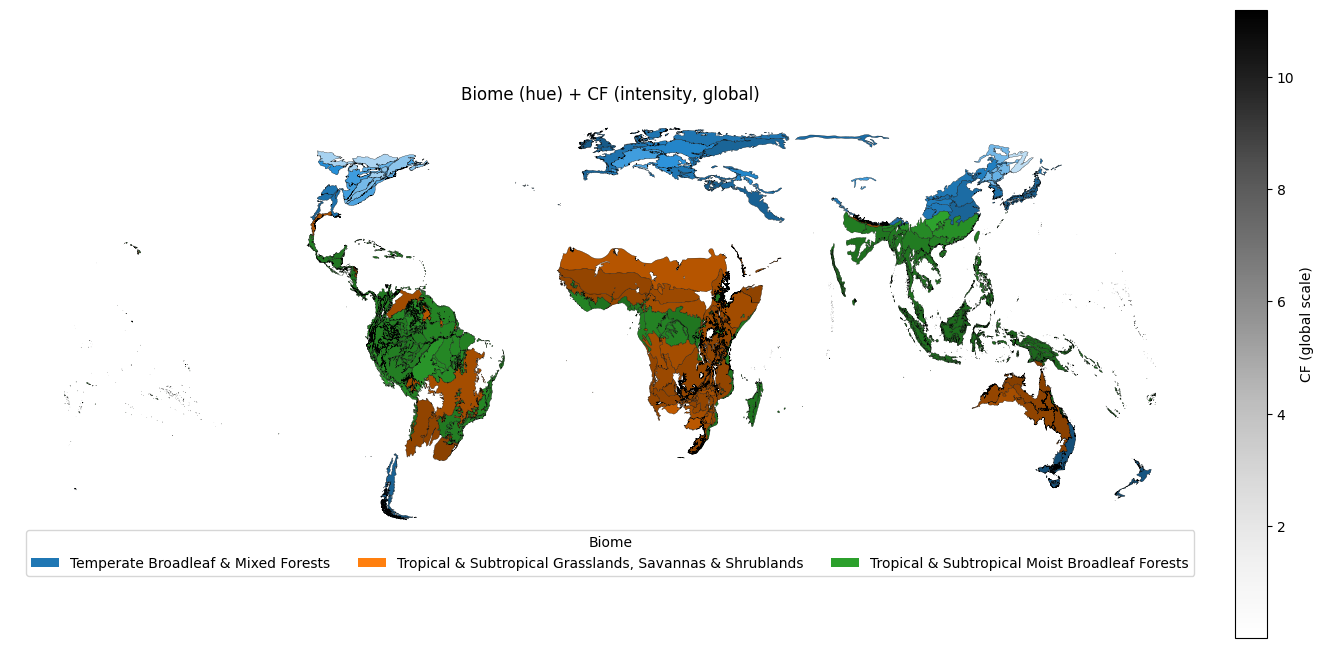

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.cm import ScalarMappable
import colorsys

# --- Data ---
gdf = acid_er.copy()
gdf = gdf[gdf["BIOME_NAME"].notna() & gdf["cf"].notna()].copy()
gdf = gdf[(gdf["flow_name"]=="nh3") & (gdf["BIOME_NAME"].isin(['Temperate Broadleaf & Mixed Forests','Tropical & Subtropical Grasslands, Savannas & Shrublands', 'Tropical & Subtropical Moist Broadleaf Forests']))]

# --- biome base colors (categorical) ---
biomes = sorted(gdf["BIOME_NAME"].unique())
cmap = plt.get_cmap("tab10")
biome_base = {b: cmap(i % cmap.N) for i, b in enumerate(biomes)}

# --- global normalization for CF intensity ---
#vmin, vmax = np.nanpercentile(gdf["cf"], [1, 99])  # robust global scale
vmin = np.min(gdf["cf"])
vmax = np.max(gdf["cf"])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
gdf["_cf01"] = norm(gdf["cf"].to_numpy())

def biome_intensity_color(base_rgba, t, lo=0.25, hi=0.85):
    r, g, b, a = base_rgba
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l2 = lo + t * (hi - lo)           # lightness encodes CF
    r2, g2, b2 = colorsys.hls_to_rgb(h, l2, s)
    return (r2, g2, b2, 1.0)

gdf["_plot_color"] = [
    biome_intensity_color(biome_base[b], t)
    for b, t in zip(gdf["BIOME_NAME"], gdf["_cf01"])
]

# --- plot ---
fig, ax = plt.subplots(figsize=(14, 8))
gdf.plot(ax=ax, color=gdf["_plot_color"], linewidth=0.2, edgecolor="black")
ax.set_axis_off()
ax.set_title("Biome (hue) + CF (intensity, global)")

# --- biome legend (categorical) ---
handles = [Patch(facecolor=biome_base[b], edgecolor="none", label=b) for b in biomes]
ax.legend(
    handles=handles,
    title="Biome",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    borderaxespad=0.0,
    frameon=True
)

# --- global CF intensity legend (continuous) ---
# Use a neutral grayscale ramp so it reads as "intensity" not "biome color"
sm = ScalarMappable(norm=norm, cmap="Greys")
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, fraction=0.025, pad=0.02)
cbar.set_label("CF (global scale)")

ax.legend(
    handles=handles,
    title="Biome",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=3,
    frameon=True
)

plt.tight_layout()
plt.show()


## SOC

### Loading data


In [22]:
soc_er_gpkg_fp = "../LEAFs/soil_erosion/soil_erosion_ecoregion.gpkg"

soc_er_geometries = gpd.read_file(soc_er_gpkg_fp, layer="geometry_layer")
soc_er_geometries = soc_er_geometries.to_crs("+proj=natearth")

soc_er_values = gpd.read_file(soc_er_gpkg_fp, layer="se_leaf_ecoregions").drop(columns = "_source_file")

In [23]:
soc_er = soc_er_geometries.merge(soc_er_values, on="OBJECTID", how="left")

In [24]:
soc_er.sort_values(by=["cf"], ascending=False).head()

,OBJECTID,ECO_NAME,BIOME_NUM,BIOME_NAME,REALM,ECO_BIOME_,ECO_ID,geometry,flow_name,cf,cf_median,cf_std
25999,328.0,Huon Peninsula montane rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,141,"MULTIPOLYGON (((14110579.229 -616085.784, 1411...",Urban,2052.479492,1900.610229,1.098878e+03
19279,244.0,Eastern Panamanian montane forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Neotropic,NO01,461,"MULTIPOLYGON (((-7529477.22 818268.547, -75297...",Urban,1899.165649,1697.285156,1.086563e+03
13999,176.0,Comoros forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Afrotropic,AF01,4,"MULTIPOLYGON (((4352376.706 -1440618.912, 4352...",Urban,1881.906982,1881.906982,0.000000e+00
56079,706.0,Sulawesi montane rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,157,"MULTIPOLYGON (((11638542.212 -547151.325, 1163...",Urban,1803.205200,1645.490356,1.004601e+03
20079,254.0,Enriquillo wetlands,9.0,Flooded Grasslands & Savannas,Neotropic,NO09,580,"MULTIPOLYGON (((-6552040.314 2039394.279, -655...",Urban,1800.513428,1800.513428,2.273737e-13


Filtering out urban...

In [25]:
soc_er = soc_er[soc_er["flow_name"] != "Urban"]

In [26]:
soc_er.sort_values(by=["cf"], ascending=False).head(20)

,OBJECTID,ECO_NAME,BIOME_NUM,BIOME_NAME,REALM,ECO_BIOME_,ECO_ID,geometry,flow_name,cf,cf_median,cf_std
50516,636.0,Sinú Valley dry forests,2.0,Tropical & Subtropical Dry Broadleaf Forests,Neotropic,NO02,546,"MULTIPOLYGON (((-7050105.559 1243387.804, -704...",Irrigated_Sweet_potatoes,1434.916382,1434.916382,0.000000
50553,636.0,Sinú Valley dry forests,2.0,Tropical & Subtropical Dry Broadleaf Forests,Neotropic,NO02,546,"MULTIPOLYGON (((-7050105.559 1243387.804, -704...",Rainfed_Sweet_potatoes,1434.916382,1434.916382,0.000000
27706,350.0,Jamaican dry forests,2.0,Tropical & Subtropical Dry Broadleaf Forests,Neotropic,NO02,535,"MULTIPOLYGON (((-7279325.404 2011958.864, -727...",Irrigated_Potatoes,1317.045288,1317.045288,0.000000
27743,350.0,Jamaican dry forests,2.0,Tropical & Subtropical Dry Broadleaf Forests,Neotropic,NO02,535,"MULTIPOLYGON (((-7279325.404 2011958.864, -727...",Rainfed_Potatoes,1317.045288,1317.045288,0.000000
50539,636.0,Sinú Valley dry forests,2.0,Tropical & Subtropical Dry Broadleaf Forests,Neotropic,NO02,546,"MULTIPOLYGON (((-7050105.559 1243387.804, -704...",Rainfed_Maize_residues_removed_from_the_field,1090.536377,1090.536377,0.000000
50501,636.0,Sinú Valley dry forests,2.0,Tropical & Subtropical Dry Broadleaf Forests,Neotropic,NO02,546,"MULTIPOLYGON (((-7050105.559 1243387.804, -704...",Irrigated_Maize_residues_removed_from_the_field,1090.536377,1090.536377,0.000000
15226,192.0,Cuban cactus scrub,13.0,Deserts & Xeric Shrublands,Neotropic,NO13,600,"MULTIPOLYGON (((-7382242.95 2229705.905, -7383...",Irrigated_Potatoes,1050.283325,1247.864014,485.302948
15263,192.0,Cuban cactus scrub,13.0,Deserts & Xeric Shrublands,Neotropic,NO13,600,"MULTIPOLYGON (((-7382242.95 2229705.905, -7383...",Rainfed_Potatoes,1050.283325,1247.864014,485.302948
25956,328.0,Huon Peninsula montane rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,141,"MULTIPOLYGON (((14110579.229 -616085.784, 1411...",Irrigated_Sweet_potatoes,1032.264648,967.089539,545.638550
25993,328.0,Huon Peninsula montane rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,141,"MULTIPOLYGON (((14110579.229 -616085.784, 1411...",Rainfed_Sweet_potatoes,1032.264648,967.089539,545.638550


### Checking potatoes

Checking what happened with potatoes...

In [27]:
soc_pot_irr = soc_er[soc_er["flow_name"]=="Irrigated_Potatoes"]

In [28]:
threshold = soc_pot_irr["cf"].dropna().quantile(0.99)
top1 = soc_pot_irr[soc_pot_irr["cf"] >= threshold].sort_values("cf", ascending=False)
print(f"99th percentile threshold: {threshold} — {len(top1)} rows")
top1.head()

99th percentile threshold: 873.563864746094 — 8 rows


,OBJECTID,ECO_NAME,BIOME_NUM,BIOME_NAME,REALM,ECO_BIOME_,ECO_ID,geometry,flow_name,cf,cf_median,cf_std
27706,350.0,Jamaican dry forests,2.0,Tropical & Subtropical Dry Broadleaf Forests,Neotropic,NO02,535,"MULTIPOLYGON (((-7279325.404 2011958.864, -727...",Irrigated_Potatoes,1317.045288,1317.045288,0.000000
15226,192.0,Cuban cactus scrub,13.0,Deserts & Xeric Shrublands,Neotropic,NO13,600,"MULTIPOLYGON (((-7382242.95 2229705.905, -7383...",Irrigated_Potatoes,1050.283325,1247.864014,485.302948
20026,254.0,Enriquillo wetlands,9.0,Flooded Grasslands & Savannas,Neotropic,NO09,580,"MULTIPOLYGON (((-6552040.314 2039394.279, -655...",Irrigated_Potatoes,1005.479980,1005.479980,0.000000
25946,328.0,Huon Peninsula montane rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,141,"MULTIPOLYGON (((14110579.229 -616085.784, 1411...",Irrigated_Potatoes,986.386902,967.089539,390.295319
27386,346.0,Isthmian-Pacific moist forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Neotropic,NO01,471,"MULTIPOLYGON (((-7908309.898 817211.205, -7908...",Irrigated_Potatoes,943.579346,875.965088,309.054962


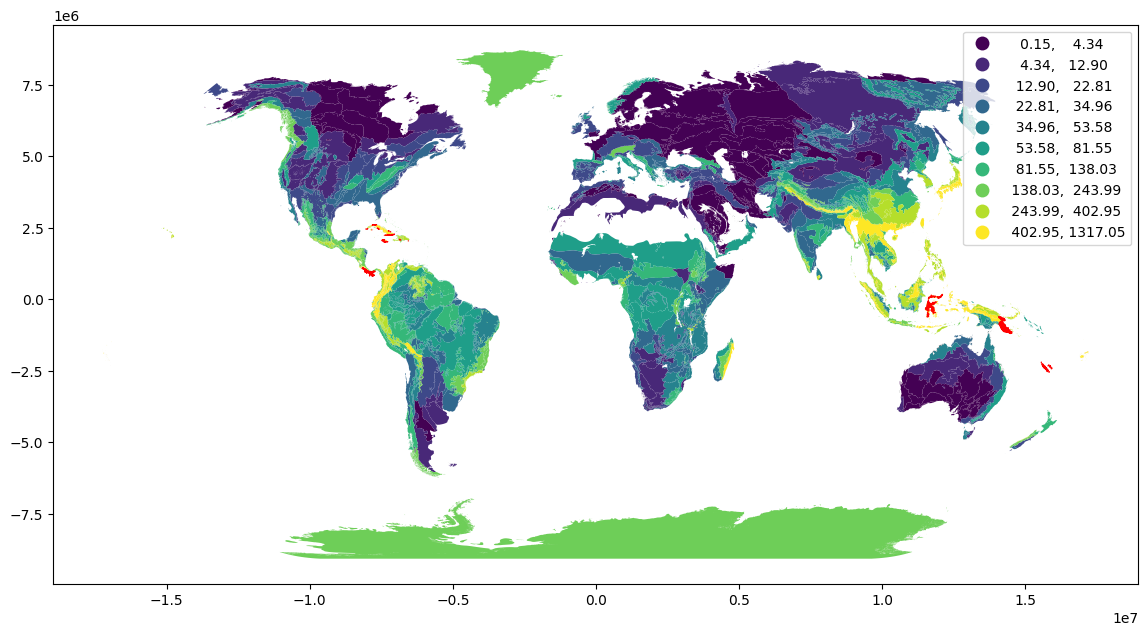

In [29]:
fig, ax = plt.subplots(figsize=(14, 8))

soc_pot_irr.plot(
    ax=ax,
    column="cf",
    legend=True,
    scheme="quantiles",
    k = 10
)

top1.plot(
    ax=ax,
    color="red",
    linewidth=0.8,
    edgecolor="red",
)

plt.show()


Loading the raster

In [52]:
soc_pot_irr_raster = "../LEAFs/SOC/rasters/Potato_irr_2030y_SOC.tif"

Raster has 1,285,480 unique values. Min: 4.92. Max: 173.95
Using quantiles
All positives route (quantiles)


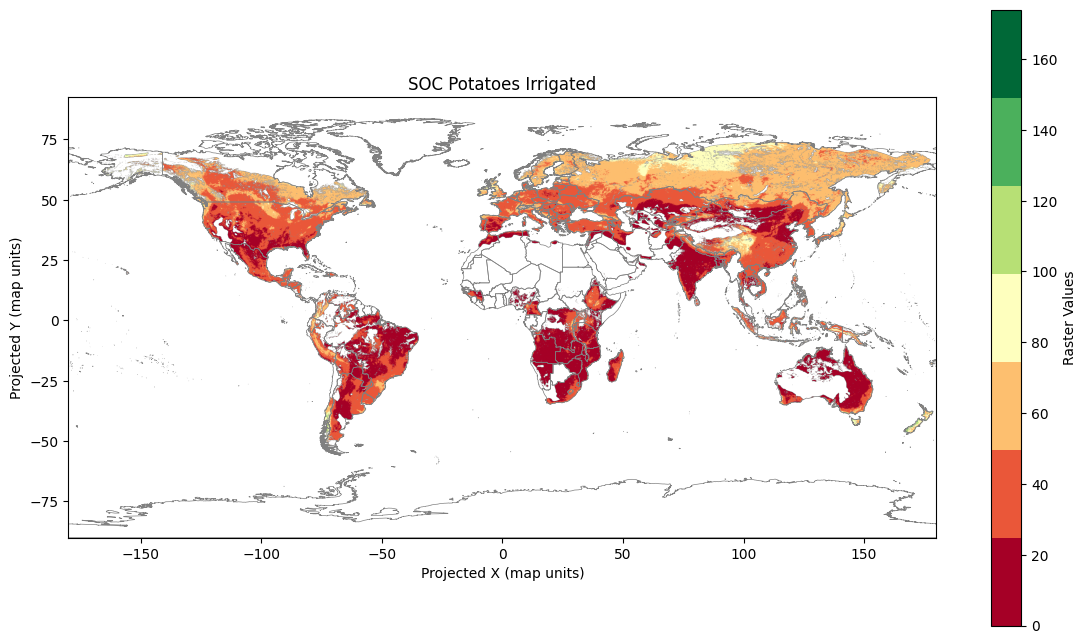

In [53]:
mp.plot_raster_on_world_extremes_cutoff(soc_pot_irr_raster, "SOC Potatoes Irrigated", quantiles=7,  perc_cutoff=0, raster_band=15, cmap="RdYlGn")

### Group of Rasters

Checking irrigated tomatoes to compare it with paper

In [30]:
soc_tom_irr = soc_er[soc_er["flow_name"]=="Irrigated_Tomatoes"]

<Axes: >

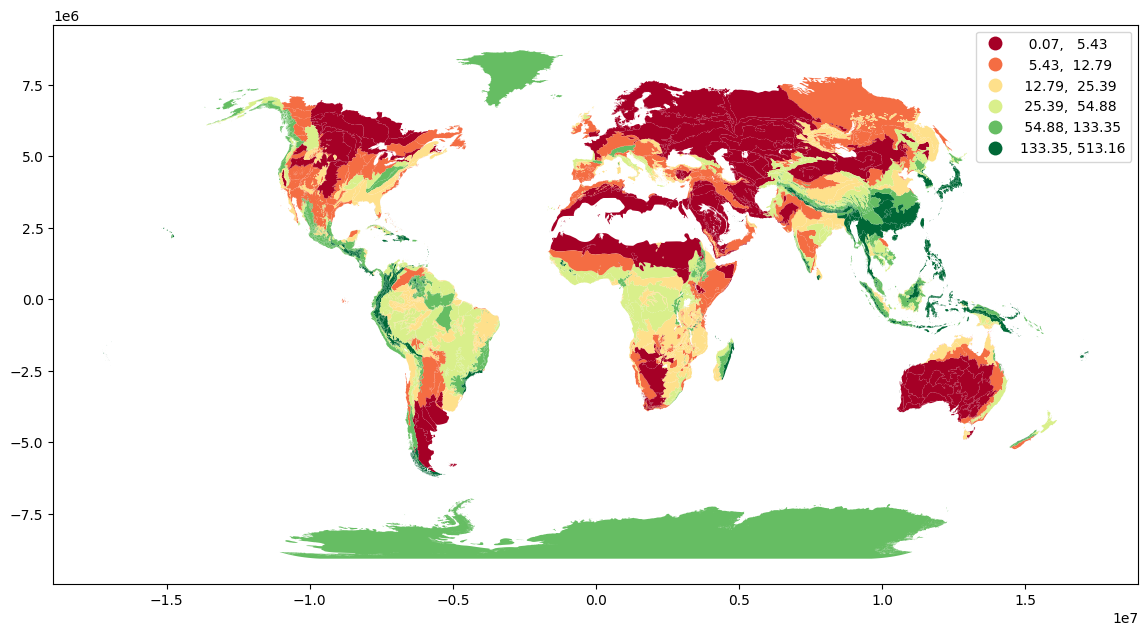

In [31]:
fig, ax = plt.subplots(figsize=(14, 8))

soc_tom_irr.plot(
    ax=ax,
    column="cf",
    legend=True,
    scheme="quantiles",
    k = 6,
    cmap="RdYlGn"
)

In [32]:
soc_tom_irr_raster = "../LEAFs/SOC/rasters/Tomato_irr_2030y_SOC.tif"

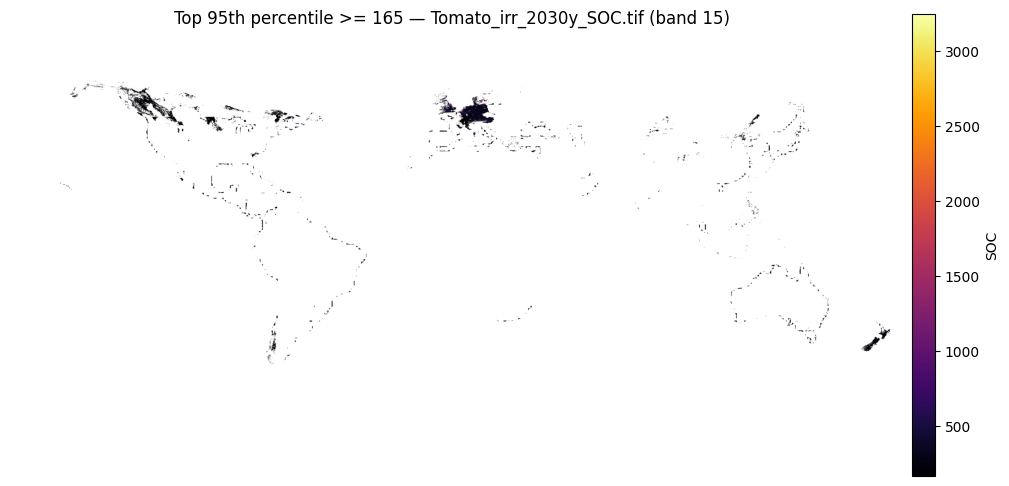

In [41]:
# plot only top 95th percentile values from soc_tom_irr_raster (use band 15 as in the later cell)
raster_fp = soc_tom_irr_raster
band = 15

da = rxr.open_rasterio(raster_fp, masked=True)

# select band robustly (label or index)
try:
    da_b = da.sel(band=band).squeeze()
except Exception:
    da_b = da.isel(band=band - 1).squeeze()

arr = da_b.values
if np.ma.isMaskedArray(arr):
    arr = arr.filled(np.nan)
arr = arr.astype(float)

valid = np.isfinite(arr)
thr = np.nanpercentile(arr[valid], 95)

arr_top95 = np.where(arr >= thr, arr, np.nan)

# plot
x0 = float(da_b["x"].values.min()); x1 = float(da_b["x"].values.max())
y0 = float(da_b["y"].values.min()); y1 = float(da_b["y"].values.max())
extent = (x0, x1, y0, y1)

fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(arr_top95, origin="upper", extent=extent, cmap="inferno")
ax.set_title(f"Top 95th percentile >= {thr:.3g} — {raster_fp.split('/')[-1]} (band {band})")
ax.set_axis_off()
fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02).set_label("SOC")
plt.show()

In [45]:
importlib.reload(mp)

<module 'sbtn_leaf.map_plotting' from 'C:\\Users\\loyola\\OneDrive - World Wildlife Fund, Inc\\Documents\\203. Python projects\\SBTN_Test\\src\\sbtn_leaf\\map_plotting.py'>

Raster has 1,006,241 unique values. Min: 16.97. Max: 164.94
Using quantiles
All positives route (quantiles)


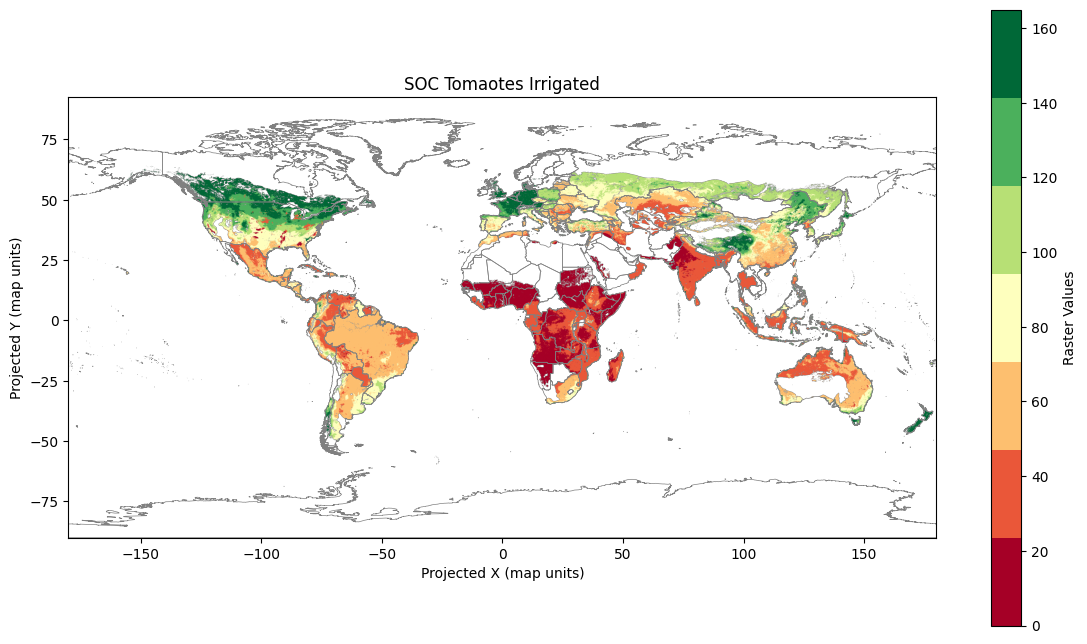

In [56]:
mp.plot_raster_on_world_extremes_cutoff(soc_tom_irr_raster, "SOC Tomaotes Irrigated", quantiles=7,  perc_cutoff=5, raster_band=15, cmap="RdYlGn")

In [43]:
soc_er["flow_name"].unique()

array(['Broadleaf_Deciduous_Boreal_dry',
       'Broadleaf_Deciduous_Boreal_moist',
       'Broadleaf_Deciduous_Cold_temperate_dry',
       'Broadleaf_Deciduous_Cold_temperate_moist',
       'Broadleaf_Deciduous_Subtropical', 'Broadleaf_Deciduous_Tropical',
       'Broadleaf_Deciduous_Warm_temperate_dry',
       'Broadleaf_Deciduous_Warm_temperate_moist', 'Grassland',
       'Irrigated_Apples', 'Irrigated_Bananas',
       'Irrigated_Barley_residues_left_on_the_field',
       'Irrigated_Barley_residues_removed_from_the_field',
       'Irrigated_Cabbages', 'Irrigated_Carrots', 'Irrigated_Cocoa',
       'Irrigated_Coconuts', 'Irrigated_Coffee', 'Irrigated_Grapes',
       'Irrigated_Groundnuts',
       'Irrigated_Maize_residues_left_on_the_field',
       'Irrigated_Maize_residues_removed_from_the_field',
       'Irrigated_Oil_palm', 'Irrigated_Olives', 'Irrigated_Onions',
       'Irrigated_Oranges', 'Irrigated_Potatoes',
       'Irrigated_Rapeseed_residues_left_on_the_field',
       'Irrig